### On va comparer numériquement l'intégration de Riemann et celle de Lebesgue

On se donne la fonction $f$ définie sur $[0,1]$ par :

\begin{equation}
f(x)=ax^2+bx+c+\sin(4\pi x)+10\exp(-100(x-0,5)^2)
\end{equation}

avec $a=0,5;b=10;c=3$. On commence par tracer le graphe de $f$ et donner la valeur de son intégrale par la fonction quad. On note $L=0$ et $R=1$

Intégrale exacte = 6.9391205175694575


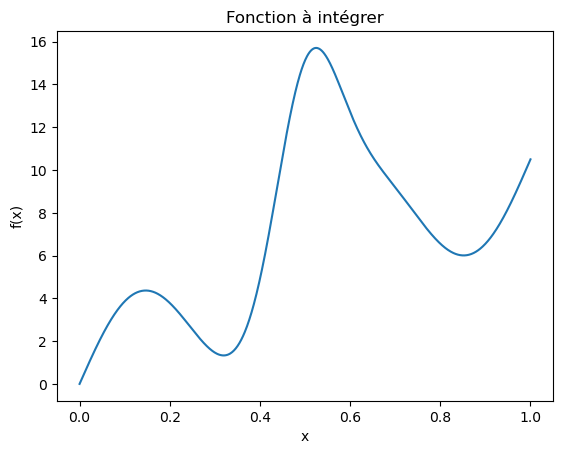

In [1]:
from scipy.integrate import quad
import numpy as np
import matplotlib.pyplot as plt

# ----------------------------------------------------------------------
# Paramètres
a = 0.5
b = 10
c = 3

# ----------------------------------------------------------------------
# Fonctions
def fct(x):
    """Fonction à intégrer."""
    return a * x**2 + b * x + c * np.sin(4 * np.pi * x) \
           + 10 * np.exp(-100 * (x - 0.5)**2)

def fct_xx(x):
    """Deuxième dérivée (optionnelle, pas utilisée directement ici)."""
    return 2 * a \
           - c * (4 * np.pi)**2 * np.sin(4 * np.pi * x) \
           + 10 * 40000 * (x - 0.5) * np.exp(-100 * (x - 0.5)**2)

# ----------------------------------------------------------------------
# Référence par intégration exacte
L, R = 0, 1
I, _ = quad(fct, L, R,)
print("Intégrale exacte =", I)

# ----------------------------------------------------------------------
# Tracé de la fonction
npt = 1000
x = np.linspace(L, R, npt)
plt.plot(x, fct(x), "-")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.title("Fonction à intégrer")
plt.show()

On va maintenant calculer une approximation de l'intégrale de $f$ par la méthode des rectangles à gauche: pour $N$ un nombre de points donné, le pas $h$ vaut $(R-L)/N$ et

\begin{equation}
\int_L^R f(x)dx=\sum_{j=1}^N f(L+jh)h
\end{equation}

In [8]:
# nombre de points de subdivision (pas fixé)
npt = 1000  
h = (R - L) / npt

# intégrale de Riemann (méthode des rectangles à gauche)
IR = 0
for j in range(npt):
    xj = L + j * h
    IR += fct(xj) * h

print(f"Intégrale de Riemann avec pas fixe (npt={npt}) = {IR}")
print(f"Erreur = {abs(IR - I)}")

Intégrale de Riemann avec pas fixe (npt=1000) = 6.933870600902785
Erreur = 0.005249916666672405


On retrouve une valeur proche de celle trouvée à l'aide la fonction quad. L'erreur est de l'ordre de $10^{-3}$

On se propose maintenant d'approcher l'intrégrale de $f$ par l'intégration de Lebesgue 

\begin{equation}
\int_{L}^{R} f(x)\,dx 
\;\approx\; \sum_{j=0}^{N-1} 
\mu\!\left(\{x \in [L,R] \mid f(x) \geq y_j\}\right)\,\Delta y
\end{equation}

avec $y_j=y_{\min}+j\Delta y$ et $\Delta y=\frac{y_{\max}-y_{\min}}{N-1}$ 

In [9]:
# bornes de l'intégration
L, R = 0, 1
npt = 5000  # maillage fin pour approximer les ensembles {x : f(x) >= y}

# discrétisation en x pour évaluer f
x = np.linspace(L, R, npt)
fx = fct(x)

# bornes verticales
ymin, ymax = fx.min(), fx.max()

# subdivisions en y (Lebesgue)
N = 200
dy = (ymax - ymin) / (N - 1)
y_vals = np.linspace(ymin, ymax, N)

# intégrale de Lebesgue
IL = 0
for y in y_vals:
    # mesure des x tels que f(x) >= y
    measure = np.sum(fx >= y) * (R - L) / npt
    IL += measure * dy

print(f"Intégrale de Lebesgue (N={N}, npt={npt}) = {IL}")
print(f"Erreur = {abs(IL - I)}")

Intégrale de Lebesgue (N=200, npt=5000) = 6.978562248638817
Erreur = 0.039441731069359776


On implémente maintenant une code qui met en œuvre une stratégie d’intégration basée sur la construction
d’un maillage adaptatif. Contrairement à une quadrature de Riemann classique où les points
sont uniformément répartis, on introduit ici une métrique $M_i$ qui mesure la difficulté
d’approximation locale de la fonction. Cette métrique dépend notamment de la courbure de la
fonction ainsi que des bornes $h_{\min}$ et $h_{\max}$ qui contrôlent la taille minimale et maximale
des mailles. Plus précisément, à chaque nœud $s_i$ du maillage, on définit :

\begin{equation}
\mathcal{M_i}=\max\left(\min\left(\frac{1}{\epsilon}\lvert\partial_x^2u_h(s_i)\rvert,\frac{1}{h_\min^2}\right)\frac{1}{h_\max^2}\right)
\end{equation}

où $\epsilon$ est un paramètre de tolérance. Le nouveau maillage est ensuite défini de sorte que
chaque intervalle ait une longueur unitaire dans cette métrique, concentrant ainsi les points
dans les zones où la fonction varie fortement, et améliorant la précision de l’intégrale pour
un nombre de points donné.

In [14]:
hmin = (R-L) / 100
hmax = (R-L) / 3
epsilon = 0.01

itermax_lebesgue = 10
nptL = np.zeros(itermax_lebesgue).astype(int)
eps = np.zeros(itermax_lebesgue)
ILm = np.zeros(itermax_lebesgue)

# pas de point fixe car dérivée seconde donnée,
# comment se passer de fct_xx, même pb qu’avec une EDP
for npt in range(itermax_lebesgue):
    epsilon = 0.9
    x = L
    u = fct(x)

    while (x < R):
        uxx = fct_xx(x)
        metric = min(max(abs(uxx) / epsilon, 1 / hmax**2), 1 / hmin**2)
        hloc = min(np.sqrt(1.0 / metric), R - x)

        # calcul d’intégrale locale
        u0 = u
        x += hloc
        u = fct(x)
        ILm[npt] += hloc * (u + u0) / 2

        nptL[npt] += 1
        eps[npt] = epsilon

    error = abs(I - ILm[npt])
    if (error < 1.e-3):
        break

print("Approximate Lebesgues integral epsilon, npt, error:",
      epsilon, nptL[npt], error)


Approximate Lebesgues integral epsilon, npt, error: 0.9 42 1.462816024242655


On adapte maintenant le code pour obtenir un échantillonnage qui donnera une précision de $10^{-3}$

In [5]:
import numpy as np
from scipy.integrate import quad

# ============================================================
# Fonction test et sa dérivée seconde
# ============================================================
def fct(x):
    return x**2 + np.sin(4*np.pi*x) + np.exp(-100*(x-0.5)**2)

def fct_xx(x):
    return 2 - (4*np.pi)**2*np.sin(4*np.pi*x) \
           + (20000 - 20000*(x-0.5)**2)*np.exp(-100*(x-0.5)**2)

# Intervalle
L, R = 0.0, 1.0

# Valeur de référence avec quad
I_ref, _ = quad(fct, L, R)

# ============================================================
# Paramètres
# ============================================================
hmin = (R - L) / 100
hmax = (R - L) / 3
tol = 1e-3
itermax_lebesgue = 20

# ============================================================
# Boucle avec epsilon qui varie
# ============================================================
epsilon = 1.0   # valeur initiale
for npt in range(itermax_lebesgue):

    x = L
    u = fct(x)
    IL = 0.0
    n_points = 0

    while x < R:
        uxx = fct_xx(x)

        metric = min(
            max(abs(uxx)/epsilon, 1/hmax**2),
            1/hmin**2
        )

        hloc = min(np.sqrt(1.0/metric), R - x)

        u0 = u
        x += hloc
        u = fct(x)

        IL += hloc * (u + u0) / 2.0
        n_points += 1

    # erreur par rapport à la valeur de référence
    error = abs(I_ref - IL)

    print(f"Iter {npt:2d} | epsilon={epsilon:.4f}, "
          f"npts={n_points:5d}, val={IL:.6f}, err={error:.3e}")

    if error < tol:
        print(f"\n✅ Tolérance {tol} atteinte avec {n_points} points")
        break

    # diminuer epsilon pour raffiner (ici facteur 0.5)
    epsilon *= 0.5


Iter  0 | epsilon=1.0000, npts=   34, val=0.279254, err=2.313e-01
Iter  1 | epsilon=0.5000, npts=   38, val=0.275371, err=2.352e-01
Iter  2 | epsilon=0.2500, npts=   42, val=0.267639, err=2.429e-01
Iter  3 | epsilon=0.1250, npts=   49, val=0.357760, err=1.528e-01
Iter  4 | epsilon=0.0625, npts=   58, val=0.455080, err=5.550e-02
Iter  5 | epsilon=0.0312, npts=   68, val=0.494506, err=1.607e-02
Iter  6 | epsilon=0.0156, npts=   81, val=0.506604, err=3.975e-03
Iter  7 | epsilon=0.0078, npts=   90, val=0.509611, err=9.677e-04

✅ Tolérance 0.001 atteinte avec 90 points
